# Libraries

In [ ]:
# basic libraries
import pandas as pd
import numpy as np
import cv2,os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# sklearn and colab libraries
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import hamming_loss,jaccard_similarity_score,accuracy_score,confusion_matrix
from google.colab import drive
import io,pickle

# tensorflow libraries
import tensorflow as tf
import copy  
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.metrics import accuracy
import tensorflow_hub as hub
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose,MaxPooling2D,  GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Layer,LeakyReLU
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, AveragePooling2D, Activation

# sme mathmatical libraries.
from time import time
from random import random
from PIL import Image
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook
import time,math,operator,datetime
import warnings
warnings.filterwarnings("ignore")
!pip install -U tensorboard_plugin_profile
import tensorboard_plugin_profile
import sys
from tensorflow.keras import backend as K

from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/CaseStudy3/UtilityModule/')
from utility import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.1MB 2.8MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Kaggle Score

![alt text](https://i.imgur.com/rZYcPBI.png)

# Data pipeline functions

In [ ]:
"""Take the Filename of the image and encoded 4 channel mask and gives Image and decode mask
eg : 256,1600 --> 256,800"""
@tf.function
def rle_decode_tf_test(filename, mask_rle):
    # Iamge Processing
    # load the raw data from the file as a string
    image = tf.io.read_file(filename)
    # convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image)
    random_number = tf.random.uniform(())

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 800])

    # Decoding of the encdoed RLE
    shape = tf.convert_to_tensor((1600,256), tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    # Reshape into mask
    mask  = tf.transpose(tf.reshape(mask_flat, shape)[::2,::])
    return image,mask	

"""Take the Filename of the image and provide the resized image"""
@tf.function
def rle_decode_tf_test_infer(filename,y):
  # Iamge Processing
  # load the raw data from the file as a string
  image = tf.io.read_file(filename)
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_jpeg(image)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 800])
  return image,y    

"""Take the Filename of the image and provide the resized image"""
@tf.function
def preprocessing(filename,y_test):
  # load the raw data from the file as a string
  image = tf.io.read_file(filename)
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_jpeg(image)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 800])
  return image,y_test    
# Metrics
@tf.function
def DiceCoef(y_true,y_pred):
  y_true =  tf.cast(y_true,'float32')
  y_pred =  tf.cast(y_pred,'float32')
  if tf.reduce_sum(y_true) == 0 and tf.reduce_sum(y_pred) == 0:
    dice_score = 1.0
  else: 
    intersection = tf.reduce_sum(y_true * y_pred)
    dice_score = (2 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
    dice_score = tf.cast(dice_score,'float32')
  return dice_score  

def dice_metric(str_true,str_pred):
  if str_true=='' or str_true== '0'  and str_pred=='' or str_pred=='0':
      return 1
  elif str_true!='' and str_pred!='':
      y_true_f = rle2mask(str_true).flatten() 
      y_pred_f = rle2mask(str_pred).flatten() 
      intersection = sum(y_true_f * y_pred_f)
      return np.round((2. * intersection + K.epsilon()) / (sum(y_true_f) + sum(y_pred_f) + K.epsilon()),8)
  else: 
      return 0    

# Model Load

In [ ]:
# Reloading all the saved models
binary = '/content/gdrive/My Drive/CaseStudy3/Inference/binary1'
Multilabel = '/content/gdrive/My Drive/CaseStudy3/Inference/multilabel2_2_updated'
Class1 = '/content/gdrive/My Drive/CaseStudy3/Inference/Class1
Class2 = '/content/gdrive/My Drive/CaseStudy3/Inference/Class2'
Class3 = '/content/gdrive/My Drive/CaseStudy3/Inference/Class3'
Class4 = '/content/gdrive/My Drive/CaseStudy3/Inference/Class4'

binarymodel = tf.saved_model.load(binary)
multilabelmodel = tf.saved_model.load(Multilabel)
Class1 = tf.saved_model.load(Class1)
Class2 = tf.saved_model.load(Class2)
Class3 = tf.saved_model.load(Class3)
Class4 = tf.saved_model.load(Class4)

# Inference data

In [ ]:
# creating dataframe for test
"""
This function gives the dataset of the test images, this is the data we will feed in our data pipeline.
"""
def Test_set_call():
  # Test image directory
  test_set_path = f'/content/gdrive/My Drive/CaseStudy3/severstal-steel-defect-detection_unzip/test_images'
  start_time = time.time()
  test_set = pd.DataFrame()
  filename_list = []
  for filename in os.listdir(test_set_path): # Loading all the image's names in the dataframe
    filename_list.append(filename)
  test_set["ImageId"] = filename_list
  # Setting the Id as unique key inthe dataframe because i have to give this ID in the custome generator while predicting.
  test_set.reset_index(inplace=True)
  test_set.rename(columns={'index': 'ID'}, inplace=True)
  print(f"Cell execution time : {np.round((time.time() - start_time),2)} seconds.")
  print(f" Test data shape : {test_set.shape}")
  test_set["ImageIdFiles"] = test_set_path+'/'+test_set["ImageId"]
  test_set = test_set.applymap(str)
  return test_set

# Evaluation data

In [ ]:
"""
This function will fetch the train dataset for evaluation of the model
"""
def check(verbose = 1):  
  train_images = "/content/gdrive/My Drive/CaseStudy3/severstal-steel-defect-detection_unzip/train_images"
  g = input("Enter do you want to evaluate the model by labeled data press Y/N : \n") 
  if g =="Y":
    data = pd.read_csv('/content/gdrive/My Drive/CaseStudy3/severstal-steel-defect-detection_unzip/train.csv')
    data = load_data()
    # update the datset 
    data =add_undefected_images(data)
    # update the dataset
    data = add_binary_label(data)
    # replace NaN value in mask_pixel_sum zero.
    data["mask_pixel_sum"] = data["mask_pixel_sum"].fillna(0)
    
    print(f"Data shape before removing duplicate images : {data.shape}")
    data["ImageIdFiles"] = train_images+'/'+data["ImageId"]
    data = data.applymap(str)
    data = data.groupby("ImageId").first()
    print(f"Data shape after removing duplicate images : {data.shape}")

    X_train, X_test, y_train, y_test = train_test_split(data, data["BinaryData"], test_size=0.192,\
                                                                random_state=42,stratify = data["BinaryData"])
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, X_train["BinaryData"], test_size=0.1963,\
                                                                random_state=42,stratify = X_train["BinaryData"])
    if verbose == 1:                               
      print(f"X_train : {X_train.shape}")
      print(f"X_test : {X_test.shape}")
      print(f"X_cv : {X_cv.shape}")
    return X_test,y_test,data    

# Binary evaluation and inference

In [ ]:
def binary_prediction_model( X_test,y_test,purpose = "Evaluation"):
  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test["ImageIdFiles"], y_test["ID"])) # y_test is just for dummy
  else:
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test["ImageIdFiles"], y_test))
  test_dataset = test_dataset.cache().map(preprocessing,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE) 
   
  prediction_list = []
  undefected_images_names = []
  with tf.device('gpu:0'):
    for indexing,(batch_x, batch_y) in tqdm_notebook(enumerate(test_dataset)): 
      predictions = binarymodel(batch_x)
      predictions = predictions.numpy().tolist()[0][0]
      prediction_list.append(predictions)
      if predictions <.45:
        undefected_images_names.append(X_test.index[indexing])
  Prediction_Binary = [1 if i>.45 else 0 for i in prediction_list]
  # Run only when purpose is evaluation
  if purpose == "Evaluation":
    plot_confusion_matrix(np.array(y_test).astype(int),Prediction_Binary)    

  print("\n##################################   Report Card    ########################################\n")
  print(f"\b 1.After binary classification filter, We found {len([i for i in Prediction_Binary if i == 0])} number of undefected images out of total {len(Prediction_Binary)}\n")
  # print(f"2. Undefected images name : {undefected_images_names}")
  return undefected_images_names,X_test

# Multilable evaluation and inference

In [ ]:
def multilabel(X_test,y_test,purpose = "Inference"):
  undefected_images_names,X_test = binary_prediction_model( X_test,y_test,purpose)

  multilabel_dataframe_ = X_test[~X_test.index.isin(undefected_images_names)]
  if purpose == "Evaluation":
    print("Preparing the data for multilabelsetting")
    multilabel_dataframe_["ClassId"] = pd.to_numeric(multilabel_dataframe_.ClassId, errors='coerce')
    multilabel_data = preprocess_multilabel_label(multilabel_dataframe_)# Preparing the data for multilabelsetting
    print(f"Multilabel data shape : {multilabel_dataframe_.shape}")
    multilabel_data = multilabel_data.applymap(str)
  else:
    print(f"Multilabel data shape : {multilabel_dataframe_.shape}")

  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((multilabel_dataframe_["ImageIdFiles"],multilabel_dataframe_.index ))
  else:
    test_dataset = tf.data.Dataset.from_tensor_slices((multilabel_data["ImageIdFiles"], multilabel_data[['defect1', 'defect2', 'defect3', 'defect4']]))
  
  test_dataset = test_dataset.cache().map(preprocessing,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

  multilabel_prediction = []
  with tf.device('gpu:0'):
    for (batch_x, batch_y) in tqdm_notebook(test_dataset): 
        predictions = multilabelmodel(batch_x)
        multilabel_prediction.append(predictions.numpy().tolist()[0])
        
  multilable_main = []
  multilabel_defected = []
  for i in multilabel_prediction:
    multilable = []
    if (i[0]>.53):
        multilable.append(1)
    else:
        multilable.append(0)
    if (i[1]>.2):
        multilable.append(1)
    else:
        multilable.append(0) 
    if (i[2]>.35):
        multilable.append(1)
    else:
        multilable.append(0)
    if (i[3]>.3):
        multilable.append(1)
    else:
        multilable.append(0)           
    if multilable[0]==0 and multilable[1]==0 and multilable[2]==0 and multilable[3]==0: 
      multilabel_defected.append(0)
    else:
      multilabel_defected.append(1)
    multilable_main.append(multilable)

  # This if condition runs only when purpose is evaluation
  if purpose =="Evaluation":
    print("\n")
    print("###############################################################")
    print("                                  Multilabel Report                              ")
    multi_ = preprocess_multilabel_label(multilabel_dataframe_)
    a = np.array(multi_[["defect1",	"defect2", "defect3",	"defect4"]])
    b = np.zeros(shape = (multi_.shape[0],4),dtype = int)

    print(f"3. Random hamming loss is  : {hamming_loss(b,a)}")
    print(f"4. Random Jaccard Simmilarity is  : {jaccard_similarity_score(b,a)}")
    print(f"5. Predicted hamming loss is  : {hamming_loss(multilable_main,a)}")
    print(f"6. Predicted Jaccard Simmilarity is  : {jaccard_similarity_score(multilable_main,a)}")
    print("###############################################################")
    print("\n\n")
    conc = pd.DataFrame(multilable_main,columns=["pred1","pred2","pred3","pred4"])
    conc.index= [i for i in multi_.index]
    comc_data = pd.concat([multi_,conc],axis=1)
    print("Multilabel prediction : defect 1")
    plot_confusion_matrix(comc_data["defect1"],comc_data["pred1"])
    print("Multilabel prediction : defect 2")
    plot_confusion_matrix(comc_data["defect2"],comc_data["pred2"])
    print("Multilabel prediction : defect 3")
    plot_confusion_matrix(comc_data["defect3"],comc_data["pred3"])
    print("Multilabel prediction : defect 4")
    plot_confusion_matrix(comc_data["defect4"],comc_data["pred4"])
    return multilable_main,multilabel_data
  else:
    return multilable_main,multilabel_dataframe_  

# Segmentation evaluation and inference

In [ ]:
def segmentation(purpose = "Evaluation"):
  if purpose == "Inference":
    # Fetching our inference dataset
    X_test = Test_set_call()
    # Calling multilabel function
    multilable_main,multilabel_data = multilabel(X_test,X_test,"Inference") 
    # X_test = X_test
  else:
    # Fetching our evaluation dataset 
    X_test,y_test,data = check(1)  
    multilable_main,multilabel_data = multilabel(X_test,y_test,purpose)

  print(" \n                             Multilabel prediction Done                   \n")
  defect1 = []
  defect2 = []
  defect3 = []
  defect4 = []

  for i in multilable_main:
    defect1.append(i[0])
    defect2.append(i[1])
    defect3.append(i[2])
    defect4.append(i[3])
  multilabel_data["pred_defect1"] = defect1
  multilabel_data["pred_defect2"] = defect2
  multilabel_data["pred_defect3"] = defect3
  multilabel_data["pred_defect4"] = defect4
  # multilabel_dataframe_ contain both binary preicted and binary real, multilabel predicted and multilabel real.

  """                              Undefected                              """
  a = multilabel_data.loc[operator.and_(multilabel_data.pred_defect1 == 0, multilabel_data.pred_defect2 == 0)]
  segment_undefected = a.loc[operator.and_(a.pred_defect3 == 0, a.pred_defect4 == 0)]
  """                              Undefected                                 """
  print(f"Note : Undefected images after multilabel  : {len(segment_undefected)}")

  multilabel_data = multilabel_data[~multilabel_data.index.isin(segment_undefected.index.values)]
  segment_df_1 = multilabel_data[multilabel_data["pred_defect1"]==1]
  segment_df_2 = multilabel_data[multilabel_data["pred_defect2"]==1]
  segment_df_3 = multilabel_data[multilabel_data["pred_defect3"]==1]
  segment_df_4 = multilabel_data[multilabel_data["pred_defect4"]==1] 

  segment_df_1["Pred_ClassId"] = 1
  segment_df_2["Pred_ClassId"] = 2
  segment_df_3["Pred_ClassId"] = 3
  segment_df_4["Pred_ClassId"] = 4 

  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_1["ImageIdFiles"],segment_df_1.index))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test_infer,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  else:    
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_1["ImageIdFiles"], segment_df_1["EncodedPixels"]))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  predictions_tensor1 = []

  ################################## Class 1 prediction ##################################  
  dicescore_tensor = tf.Variable(tf.zeros((len(segment_df_1))))
  predictions_tensor = tf.Variable(tf.zeros((len(X_test),256,800)))
  with tf.device('gpu:0'):
    for batch,(batch_x, batch_y) in tqdm_notebook(enumerate(test_dataset)): 
      # batch_x = tf.cast(batch_x,dtype = tf.dtypes.float64)
      predictions = Class1(batch_x)
      # predictions = tf.reduce_mean(predictions,0)
      predictions = predictions[-1][:,:,:,0]
      predictions = tf.cast(predictions, dtype=tf.float32)
      predictions = np.where(predictions[0,:,:] >= 0.5, 1, 0)
      predictions_tensor[batch].assign(predictions)
      if purpose == "Evaluation":
        dicescore_tensor[batch].assign(DiceCoef(batch_y,predictions))
      predictions = tf.expand_dims(predictions, 2)
      predictions = mask2rle(tf.image.resize(predictions,(256,1600)).numpy())
      predictions_tensor1.append(predictions) 
  if purpose == "Evaluation":         
    print(f"Dice Score for class 1 is : , {tf.reduce_sum(dicescore_tensor)/(batch+1)}") 
    print("                           Test Dataset Images (1)")
    Image_Visualizaton(6,3,predictions_tensor,test_dataset)

  ################################## Class 2 prediction ##################################  
  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_2["ImageIdFiles"],segment_df_2.index))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test_infer,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  else:    
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_2["ImageIdFiles"], segment_df_2["EncodedPixels"]))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)

  predictions_tensor2 = []
  predictions_tensor = tf.Variable(tf.zeros((len(X_test),256,800)))
  dicescore_tensor = tf.Variable(tf.zeros((len(segment_df_2))))
  with tf.device('gpu:0'):
    for batch,(batch_x, batch_y) in tqdm_notebook(enumerate(test_dataset)): 
      # batch_x = tf.cast(batch_x,dtype = tf.dtypes.float64)
      predictions = Class2(batch_x)
      predictions = tf.reduce_mean(predictions,0)
      predictions = predictions[:,:,:,0]
      predictions = tf.cast(predictions, dtype=tf.float32)
      predictions = np.where(predictions[0,:,:] >= 0.5, 1, 0)
      predictions_tensor[batch].assign(predictions)
      if purpose == "Evaluation": 
        dicescore_tensor[batch].assign(DiceCoef(batch_y,predictions))
      predictions = tf.expand_dims(predictions, 2)
      predictions = mask2rle(tf.image.resize(predictions,(256,1600)).numpy())
      predictions_tensor2.append(predictions)      
  if purpose == "Evaluation": 
    print(f"Dice Score for class 2 is : , {tf.reduce_sum(dicescore_tensor)/(batch+1)}") 
    print("                           Test Dataset Images (2)")
    Image_Visualizaton(6,3,predictions_tensor,test_dataset)
  ################################## Class 3 prediction ##################################  
  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_3["ImageIdFiles"],segment_df_3.index))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test_infer,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  else:    
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_3["ImageIdFiles"], segment_df_3["EncodedPixels"]))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  predictions_tensor3 = []
  dicescore_tensor = tf.Variable(tf.zeros((len(segment_df_3))))
  predictions_tensor = tf.Variable(tf.zeros((len(X_test),256,800)))
  with tf.device('gpu:0'):
    for batch,(batch_x, batch_y) in tqdm_notebook(enumerate(test_dataset)): 
      # batch_x = tf.cast(batch_x,dtype = tf.dtypes.float64)
      predictions = Class3(batch_x)
      # predictions = tf.reduce_mean(predictions,0)
      predictions = predictions[-1][:,:,:,0]
      predictions = tf.cast(predictions, dtype=tf.float32)
      predictions = np.where(predictions[0,:,:] >= 0.5, 1, 0)
      predictions_tensor[batch].assign(predictions)
      if purpose == "Evaluation": 
        dicescore_tensor[batch].assign(DiceCoef(batch_y,predictions))
      predictions = tf.expand_dims(predictions, 2)
      predictions = mask2rle(tf.image.resize(predictions,(256,1600)).numpy())
      predictions_tensor3.append(predictions) 
  if purpose == "Evaluation":            
    print(f"Dice Score for class 3 is : , {tf.reduce_sum(dicescore_tensor)/(batch+1)}") 
    print("                           Test Dataset Images (3)")
    Image_Visualizaton(6,3,predictions_tensor,test_dataset)
  ################################## Class 4 prediction ##################################  
  if purpose == "Inference":
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_4["ImageIdFiles"],segment_df_4.index))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test_infer,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  else:    
    test_dataset = tf.data.Dataset.from_tensor_slices((segment_df_4["ImageIdFiles"], segment_df_4["EncodedPixels"]))
    test_dataset = test_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1).prefetch(tf.data.experimental.AUTOTUNE)
  predictions_tensor4 = []
  predictions_tensor = tf.Variable(tf.zeros((len(X_test),256,800)))
  dicescore_tensor = tf.Variable(tf.zeros((len(segment_df_4))))
  with tf.device('gpu:0'):
    for batch,(batch_x, batch_y) in tqdm_notebook(enumerate(test_dataset)): 
      # batch_x = tf.cast(batch_x,dtype = tf.dtypes.float64)
      predictions = Class4(batch_x)
      # predictions = tf.reduce_mean(predictions,0)
      predictions = predictions[-2][:,:,:,0]
      predictions = tf.cast(predictions, dtype=tf.float32)
      predictions = np.where(predictions[0,:,:] >= 0.5, 1, 0)
      predictions_tensor[batch].assign(predictions)
      if purpose == "Evaluation": 
        dicescore_tensor[batch].assign(DiceCoef(batch_y,predictions))
      predictions = tf.expand_dims(predictions, 2)
      predictions = mask2rle(tf.image.resize(predictions,(256,1600)).numpy())
      predictions_tensor4.append(predictions)      
  if purpose == "Evaluation": 
    print(f"Dice Score for class 4 is : , {tf.reduce_sum(dicescore_tensor)/(batch+1)}") 
    print("                           Test Dataset Images (4)")
    Image_Visualizaton(6,3,predictions_tensor,test_dataset)

  segment_df_1["Pred_EncodedPixels"] = predictions_tensor1
  segment_df_2["Pred_EncodedPixels"] = predictions_tensor2
  segment_df_3["Pred_EncodedPixels"] = predictions_tensor3
  segment_df_4["Pred_EncodedPixels"] = predictions_tensor4
  final_segmented_dataframe = pd.concat([segment_df_1,segment_df_2,segment_df_3,segment_df_4])
  
  main_dataset = copy.deepcopy(X_test)
  
  if purpose == "Evaluation":
    main_dataset["ImageId"] = main_dataset.index
    final_segmented_dataframe["ImageId"] = final_segmented_dataframe.index
    final_segmented_dataframe_final = final_segmented_dataframe[["ImageId","Pred_ClassId","ClassId","Pred_EncodedPixels","EncodedPixels"]]
  else:
    final_segmented_dataframe_final = final_segmented_dataframe[["ImageId","Pred_ClassId","Pred_EncodedPixels"]]
    # del final_segmented_dataframe_final["ImageIdFiles"]
  # undefected images
  undefected = main_dataset[~main_dataset.ImageId.isin(final_segmented_dataframe_final.ImageId.values)]
  del undefected["ID"]
  undefected["Pred_ClassId"] =""
  undefected["Pred_EncodedPixels"] = ""

  submission = pd.concat([final_segmented_dataframe_final,undefected])
  submission.index.rename("ID",inplace = True)
  submission.sort_values(by=['ImageId'])
  submission.fillna("", inplace=True)

  # submission['Pred_mask_pixel_sum'] = submission.apply(lambda x: rle2mask(x['Pred_EncodedPixels']).sum(),axis = 1)

  submission.reset_index(inplace = True)

  if purpose == "Evaluation":      
    # deleting the unimport column from the submission dataframe
    del submission['mask_pixel_sum']
    del submission['BinaryData']
    # replacing 0 with "" just to beatuify our datafrmae
    submission.EncodedPixels.replace(0,'',inplace = True)
    submission.ClassId.replace(0,'',inplace = True)
  else:
    del submission["ImageIdFiles"]
    del submission["ID"]
  # submission.Pred_mask_pixel_sum.replace(0,'',inplace = True)
  if purpose == "Evaluation": 
    # print mean dice score of the model
    print(f"Mean Dice Score : {np.mean(submission.apply(lambda x : dice_metric(x.EncodedPixels,x.Pred_EncodedPixels),axis=1))}")
  return submission 

# Main Functions to call for evaluation ro prediction 

In [ ]:
def evaluation(): 
  """ This function dataset dataset as the input and create a deep copy of the input dataset and send it to 
  segmentation prediction with original dataset  and give submission.csv as output"""
  # calling segmentation prediction function.
  submission = segmentation("Evaluation")
  return submission

def prediction():
 # calling segmentation prediction function.
  submission = segmentation("Inference")
  submission = submission.rename({'Pred_ClassId': 'ClassId', 'Pred_EncodedPixels': 'EncodedPixels'}, axis=1)
  print("Saving submission.csv file")
  submission.to_csv('/content/gdrive/My Drive/CaseStudy3/submission.csv', index=False)
  return submission

# Evaluation 

Enter do you want to evaluate the model by labeled data press Y/N : 
Y
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Total train images given (7095, 3)
Binary column added....
12568
Total images from the directory : 12568
Undefected images from the directory: 5902
Final data which contain repeated imagesId tags becasue these images contain multiple type defects : 429
Suffled final data shape :  (12997, 4)
Data shape before removing duplicate images : (12997, 6)
Data shape after removing duplicate images : (12568, 6)
X_train : (8160, 6)
X_test : (2414, 6)
X_cv : (1994, 6)


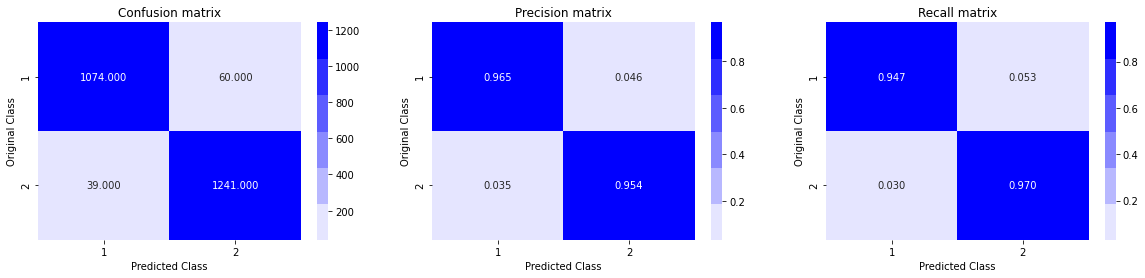


##################################   Report Card    ########################################

 1.After binary classification filter, We found 1113 number of undefected images out of total 2414

Preparing the data for multilabelsetting
Multilabel data shape : (1301, 6)





###############################################################
                                  Multilabel Report                              
3. Random hamming loss is  : 0.25
4. Random Jaccard Simmilarity is  : 0.0
5. Predicted hamming loss is  : 0.03887993553585818
6. Predicted Jaccard Simmilarity is  : 0.9182111200644641
###############################################################



Multilabel prediction : defect 1


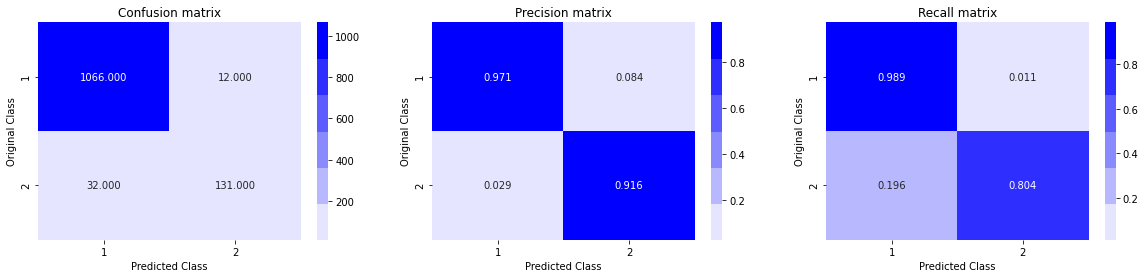

Multilabel prediction : defect 2


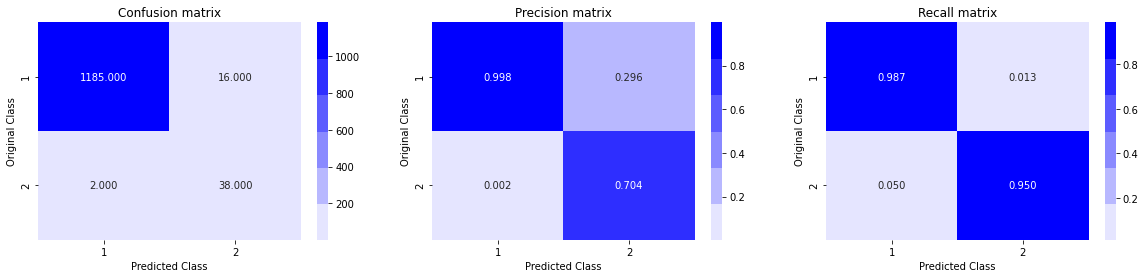

Multilabel prediction : defect 3


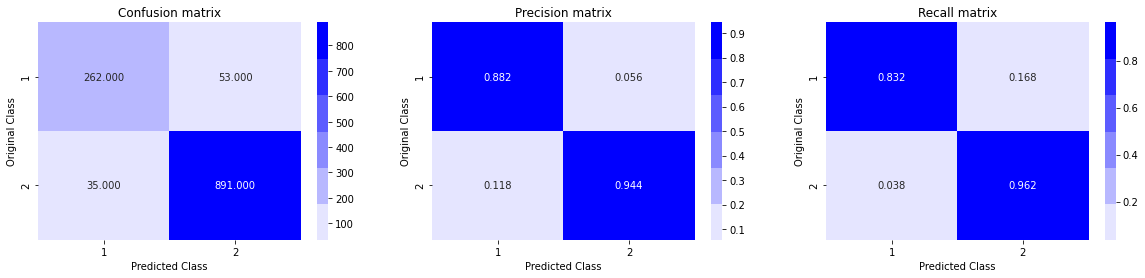

Multilabel prediction : defect 4


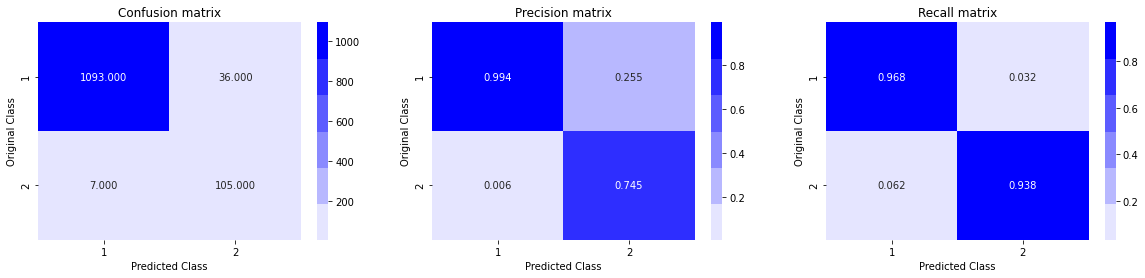

 
                             Multilabel prediction Done                   

Note : Undefected images after multilabel  : 11



Dice Score for class 1 is : , 0.6792960166931152
                           Test Dataset Images (1)


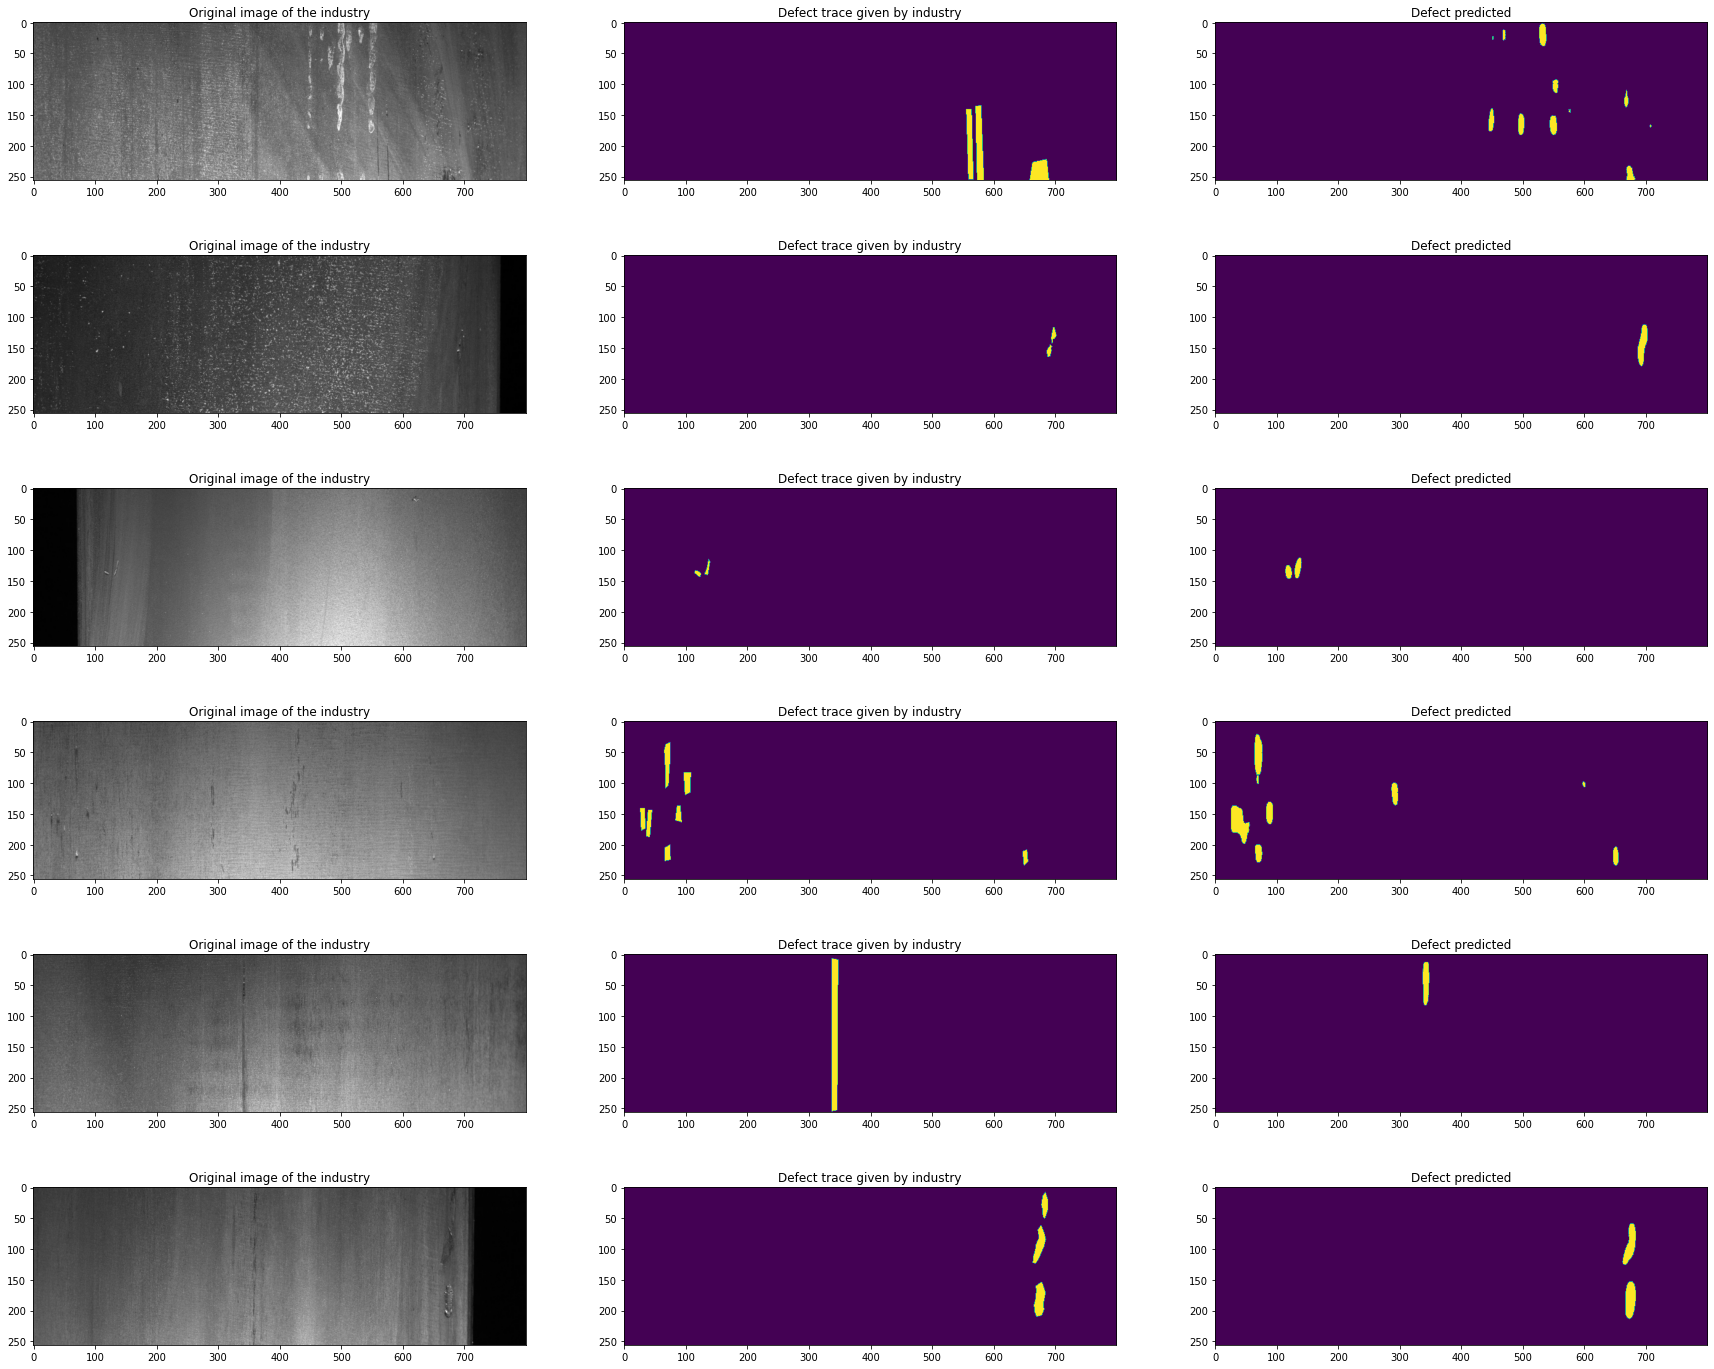


Dice Score for class 2 is : , 0.4754207134246826
                           Test Dataset Images (2)


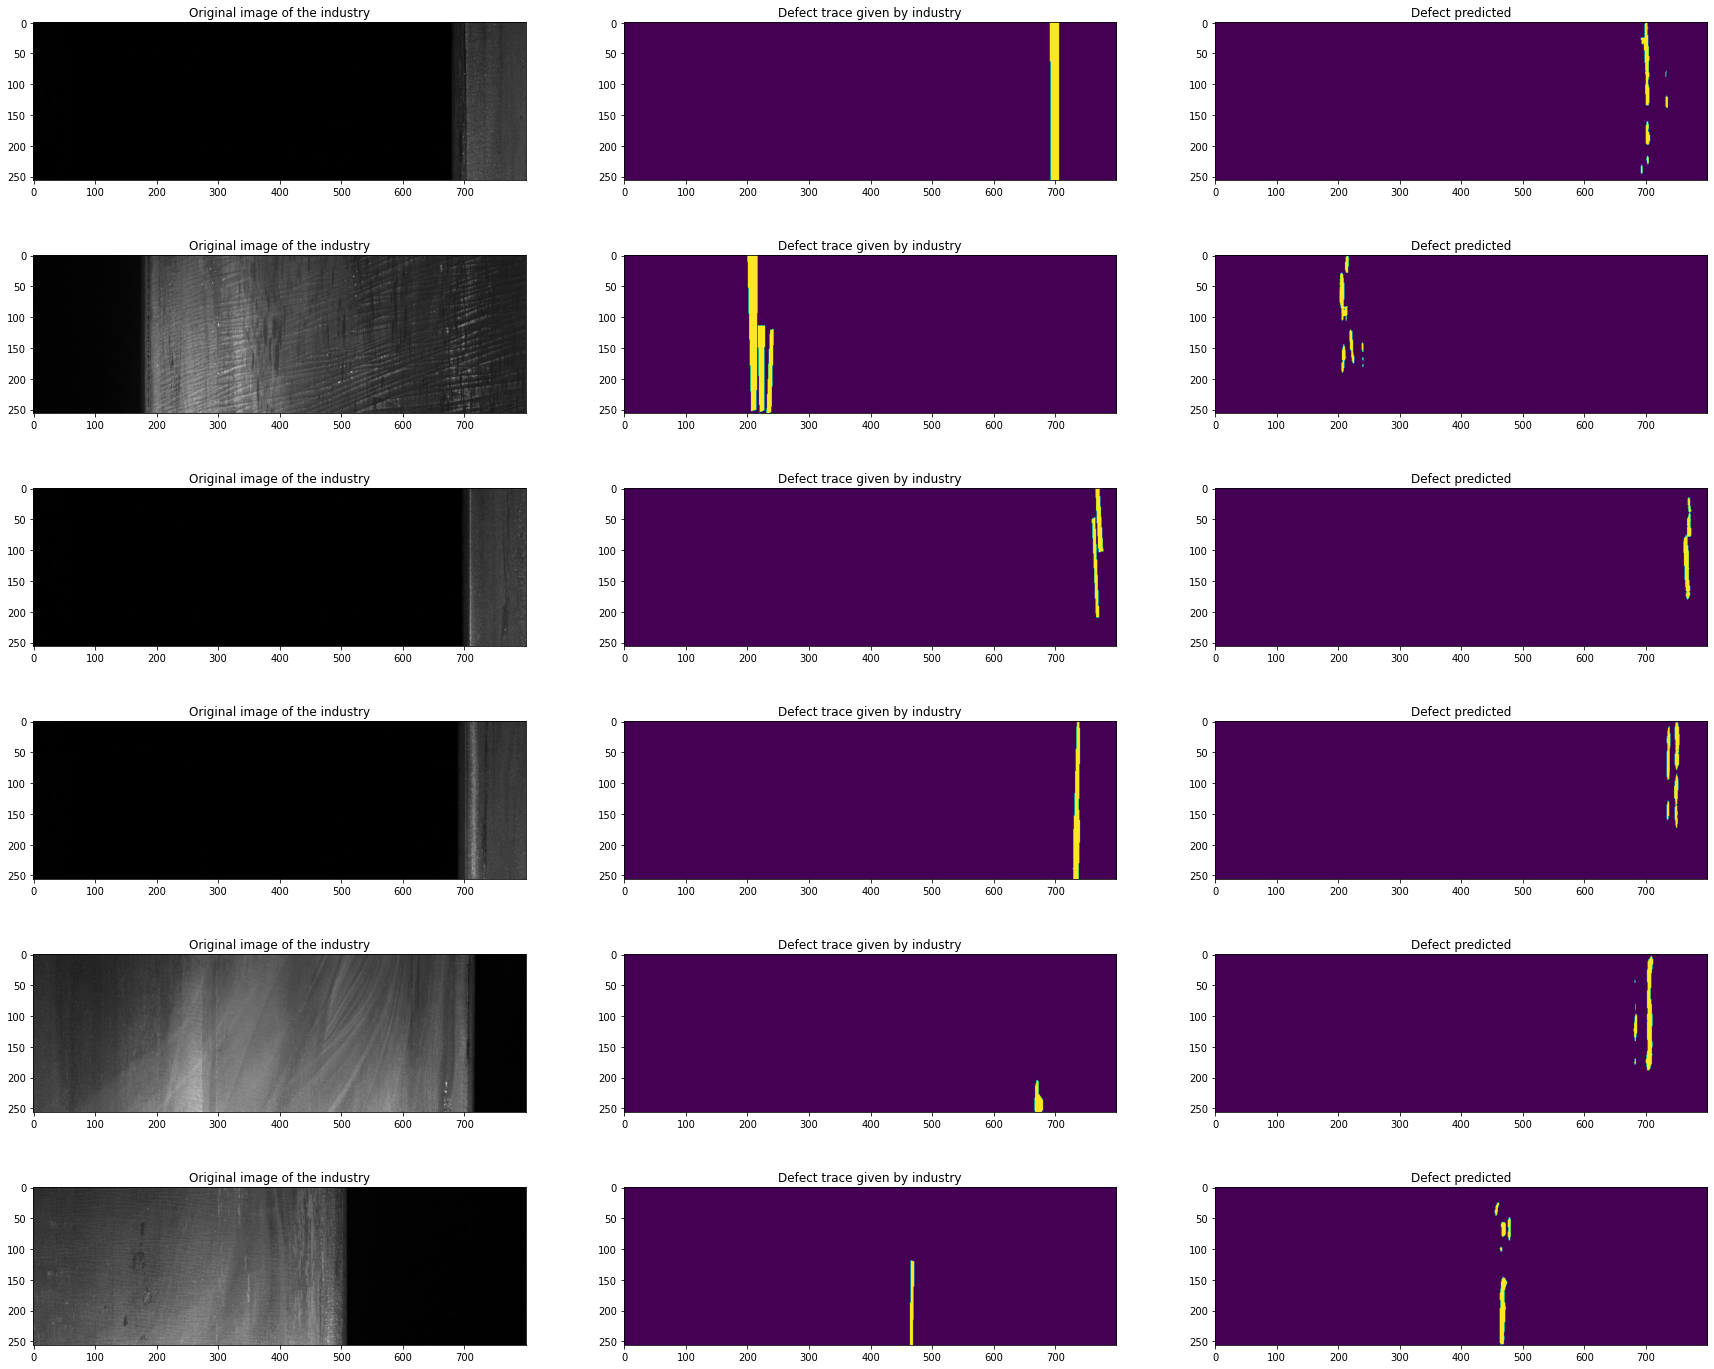


Dice Score for class 3 is : , 0.6915156841278076
                           Test Dataset Images (3)


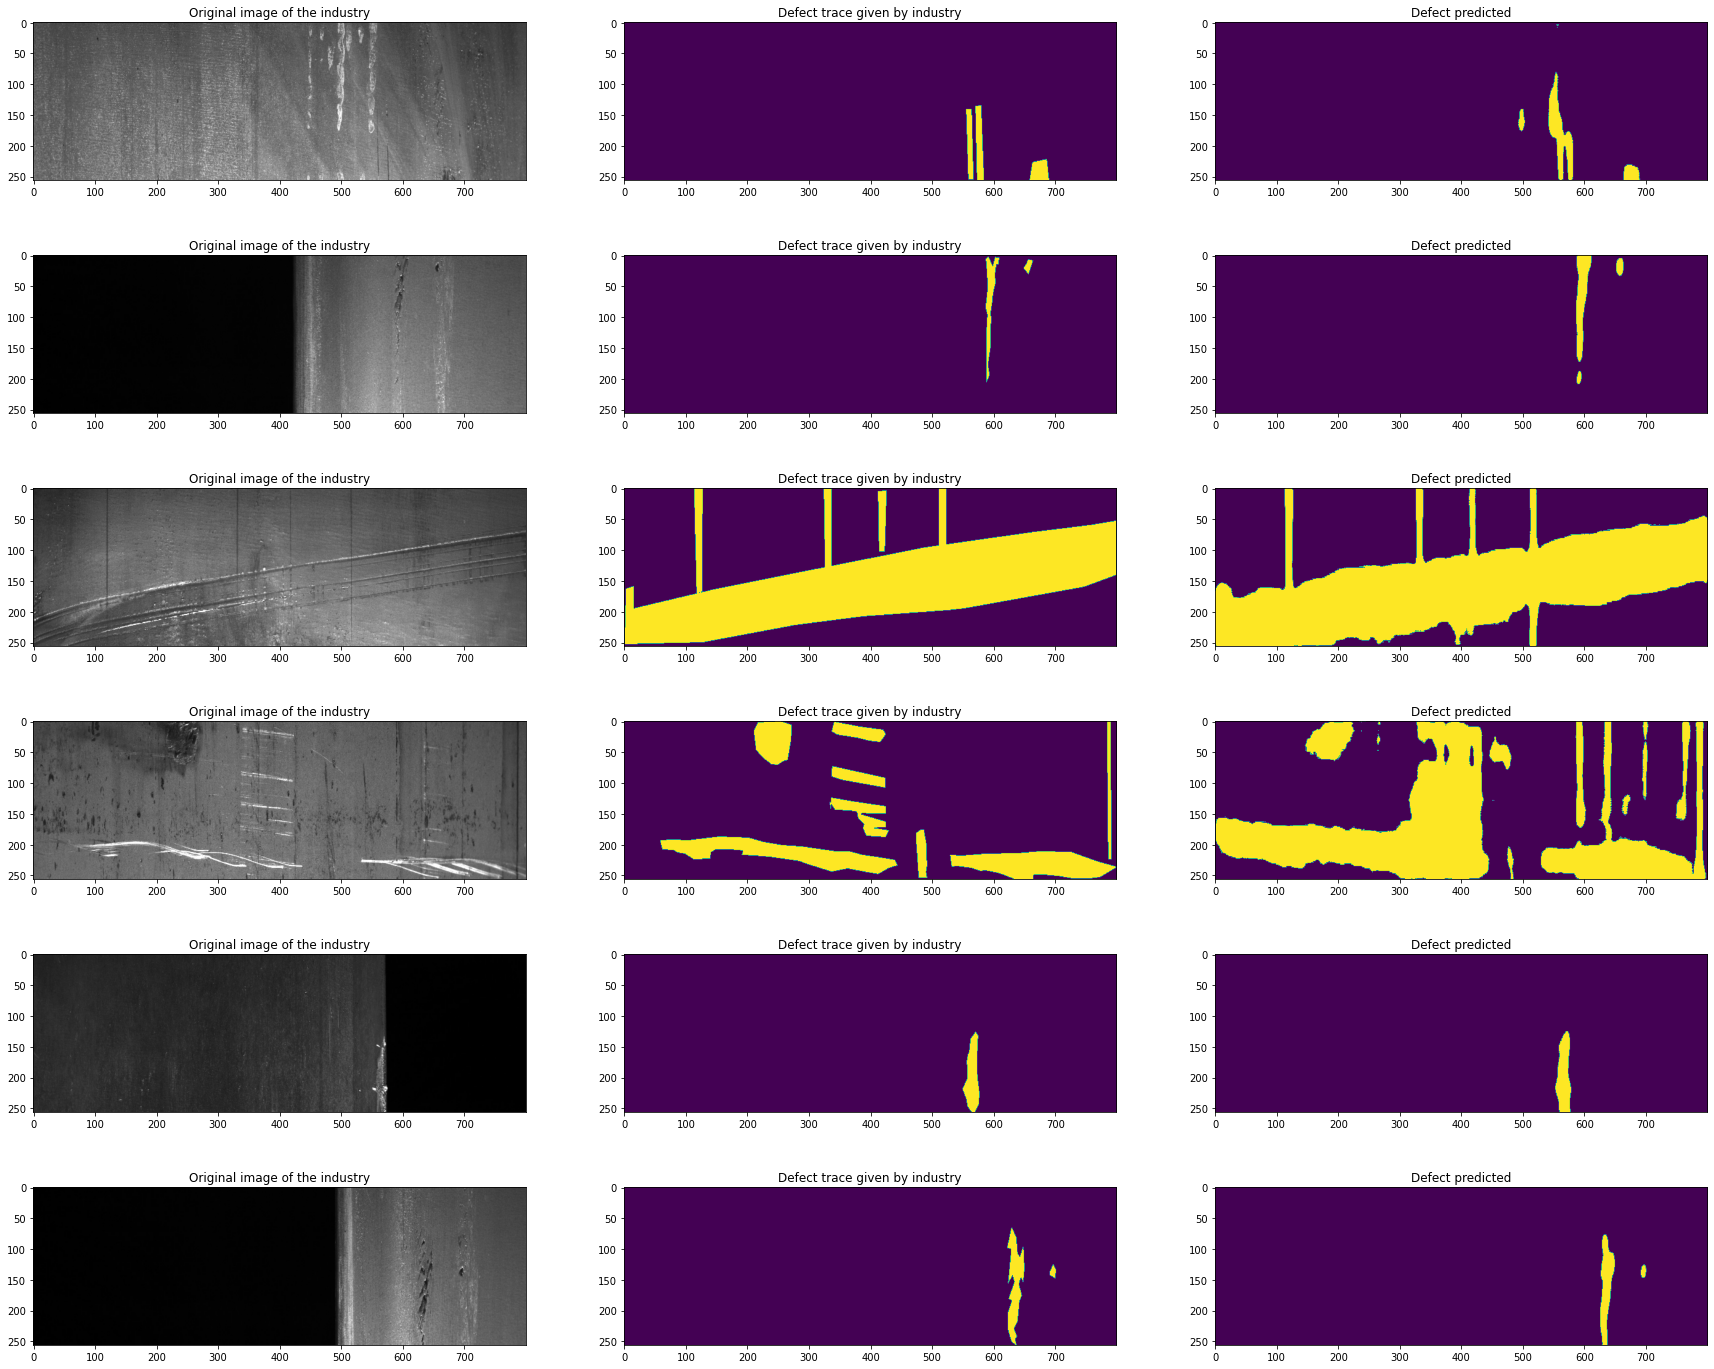


Dice Score for class 4 is : , 0.5589269995689392
                           Test Dataset Images (4)


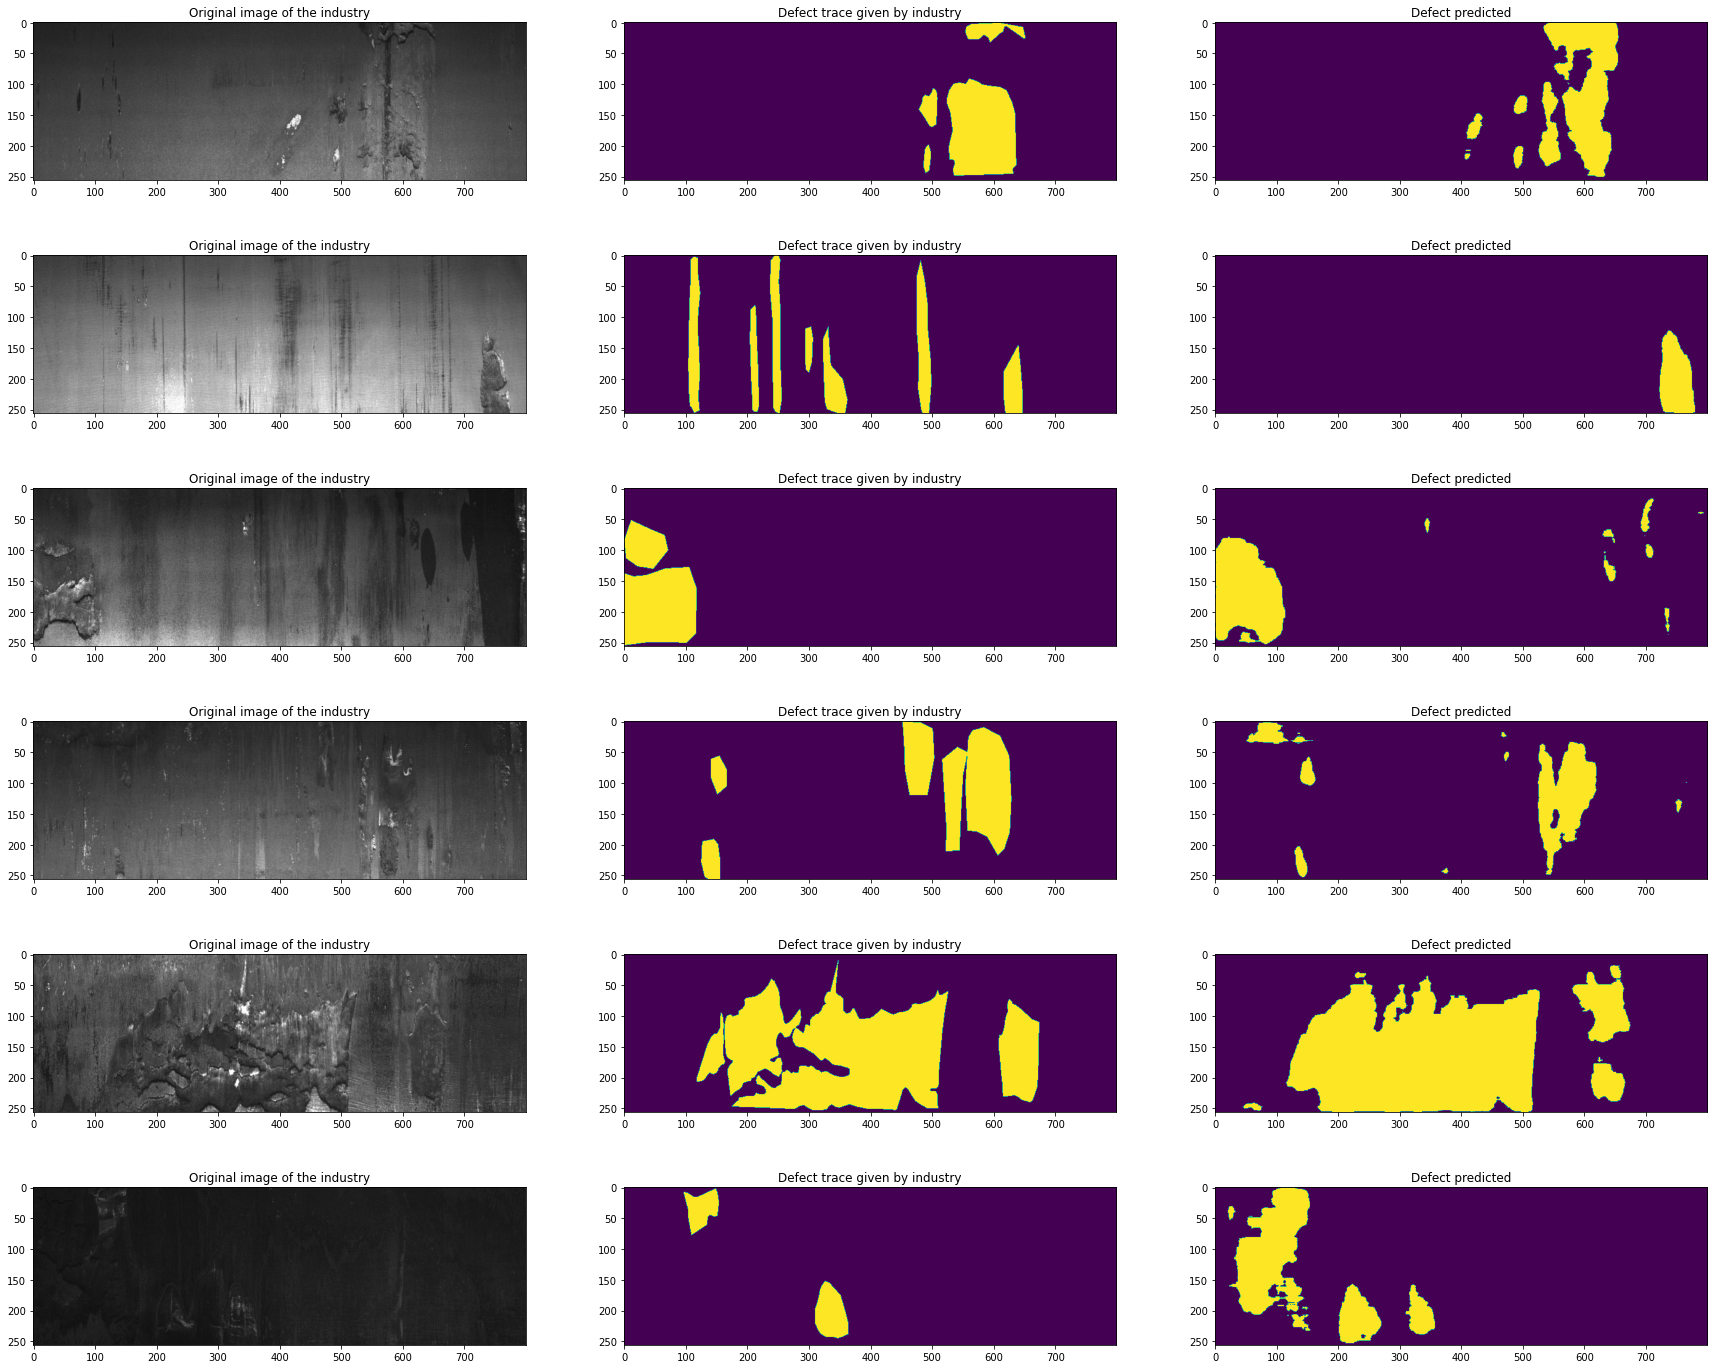

Mean Dice Score : 0.693385955632603


In [ ]:
submission = evaluation()

# Summar on the evaluation : 


*   Out of total 2414 images we found 1301 images are found undefected.
*   We can see from the binary confusion matrix that False positives are coming 60 out of 2414 and false negative 39 out of total 2414. In this defect tracing problem we should get less false positives as we dont want to say a steel is undefected but in actual it was defect. we should reduce this.
*   Multiple classification is also giving good result as hamming loss is .03 
*   On small batch we are getting .7 as dice score. 






# Prediction

In [ ]:
submission = prediction()

Cell execution time : 0.06 seconds.
 Test data shape : (5506, 2)




##################################   Report Card    ########################################

 1.After binary classification filter, We found 1788 number of undefected images out of total 5506

Multilabel data shape : (3718, 3)



 
                             Multilabel prediction Done                   

Note : Undefected images after multilabel  : 110



Saving submission.csv file
